In [ ]:
!pip install keras

!pip install gdown

In [ ]:
# load python libraries
import numpy as np
import pandas as pd
import re
import os
from bs4 import BeautifulSoup     # pulls data out of XML and HTML files
#from keras.preprocessing.text import Tokenizer # This line is commented out as it is no longer needed
from tensorflow.keras.preprocessing.text import Tokenizer # This line imports the Tokenizer from tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # This line imports the pad_sequences from tensorflow.keras.preprocessing
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget
import nltk

In [ ]:
import gdown
file_id = "13BTs2IGDMlHQSZ90w46yL4ezBCRWv95s"
output = "AmazonReviews.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
data = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=13BTs2IGDMlHQSZ90w46yL4ezBCRWv95s
From (redirected): https://drive.google.com/uc?id=13BTs2IGDMlHQSZ90w46yL4ezBCRWv95s&confirm=t&uuid=f0635c97-ca61-4f1b-ab06-4ae0660e93c6
To: /content/AmazonReviews.csv
100%|██████████| 301M/301M [00:03<00:00, 83.1MB/s]


In [ ]:
# see how many entries there are
print(data['Text'].shape)

(568454,)


In [ ]:
# limit the data for this exercise otherwise it will take too long to train
# let's limit the data from 100,000 to 10,000
#data = data[:100000]
print(data['Text'].shape)

(568454,)


In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
# Display some of the data
data[['Score','Text','Summary']].sample(5)

,Score,Text,Summary
553201,5,"Chicken pasta roni has always been a favorite for me and my husband. With in the last 2 months, we have been unable to buy this product at any of our local stores. Thankfully, Amazon.com came to...",Love Chicken Pasta Roni
440607,5,These Dark Chocolate Oranges are specifically requested by my teen children every year at Christmas. They have good chocolate and mild orange flavors that taste great together and the pieces come ...,Wonderful - Highly Recommended
467839,5,These licorice wheels are perfect for the black licorice addict! Eating three of them gives you 35% of your daily iron and even some calicium! Haribo black licorice wheels are hard to find where...,My new source for licorice wheels!
481390,5,"As with the other Earth's Best products, Chunky Orchard Fruit is a quality and wholesome food for my baby. According to the label, the ingredients are: Organic Apples, Water, Organic Apricots, Or...",Great product
147791,5,I've chosen many bolds from the Amazon offers here as well as other on line shops. I always felt there left something more to be desired in each one I tried. This is the problem with the K-cup b/c...,the real bold coffee


In [ ]:
# Remove any duplicate entries in the data
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
labels = data['Score']
labels[labels<4] = 0
labels[labels>1] = 1


In [ ]:
# map words to colloquial terms
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
# print out the first 10 entries in the data to view it to decide what to do for data cleaning
data['Text'][:10]

,Text
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')  # donload the stopwords library for use by NLTK
stop_words = set(stopwords.words('english'))

# create a function to clean the text.  Remove whiteapce, html characters, punctuation etc...
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

# store the cleaned text in a list
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# create a function to clean the summary text
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

# Call the summary_cleaner function and store the cleaned summaries in a list
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

# store the cleaned text and summaries in a dictionary
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
# drop rows with null values
data.dropna(axis=0,inplace=True)

In [ ]:
# add the text _START_ and _END_ to the summaries to easily identify they are the summaries
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
# print the first 5 reviews and their summaries
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("Score:",data['Score'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_
Score: 1


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_
Score: 0


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_
Score: 1


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_
Score: 0


Review: great taffy great price wide assortment

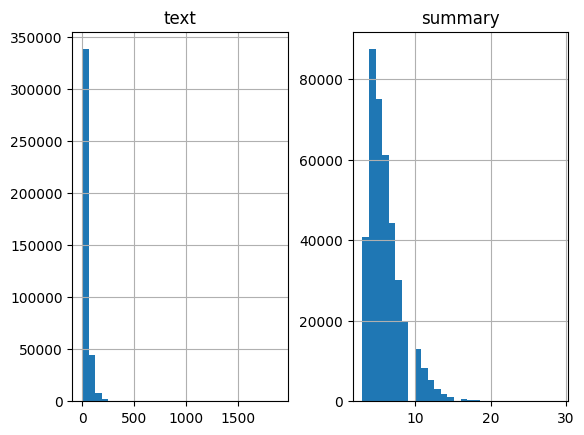

In [ ]:
# investigate the distribution of the length of the text in the data
# to help fix the max length of the sequence
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
# from histograms, decide on a text review length of 80 and a summary length of 10
max_len_text=80
max_len_summary=10

# split the data into train and test sets
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['Score'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#prepare a tokenizer for reviews on training data
max_words = 500    # the maximum number of words to keep, based on word frequency (size of the vocabulary)

x_tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
print(x_tr[1])

[ 11  83   2 423 156  61   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [ ]:
# Clear the Keras session
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# Create the model
model = Sequential()
model.add(Embedding(x_voc_size, 500, input_length=80, trainable=False))

# Bidirectional LSTM layers with dropout for regularization
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.5))

# Dense layers for classification with L1 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.5)) # Added Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=10, batch_size=128, callbacks=[early_stop], verbose=1)

# Evaluate the model on validation data
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 237s 83ms/step - accuracy: 0.7791 - loss: 1.6835 - val_accuracy: 0.7804 - val_loss: 0.5577
Epoch 2/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 233s 84ms/step - accuracy: 0.7804 - loss: 0.5766 - val_accuracy: 0.7804 - val_loss: 0.5151
Epoch 3/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 232s 84ms/step - accuracy: 0.7885 - loss: 0.5128 - val_accuracy: 0.8299 - val_loss: 0.4658
Epoch 4/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 233s 84ms/step - accuracy: 0.8338 - loss: 0.4710 - val_accuracy: 0.8484 - val_loss: 0.4496
Epoch 5/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 233s 84ms/step - accuracy: 0.8457 - loss: 0.4506 - val_accuracy: 0.8520 - val_loss: 0.4251
Epoch 6/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 232s 84ms/step - accuracy: 0.8537 - loss: 0.4377 - val_accuracy: 0.8541 - val_loss: 0.4231
Epoch 7/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 232s 84ms/step - accuracy: 0.8595 - loss: 0.4284 - val_accuracy: 0.8553 - val_loss: 0.4139
Epoch 8/10
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 233s 84ms/step - accuracy: 

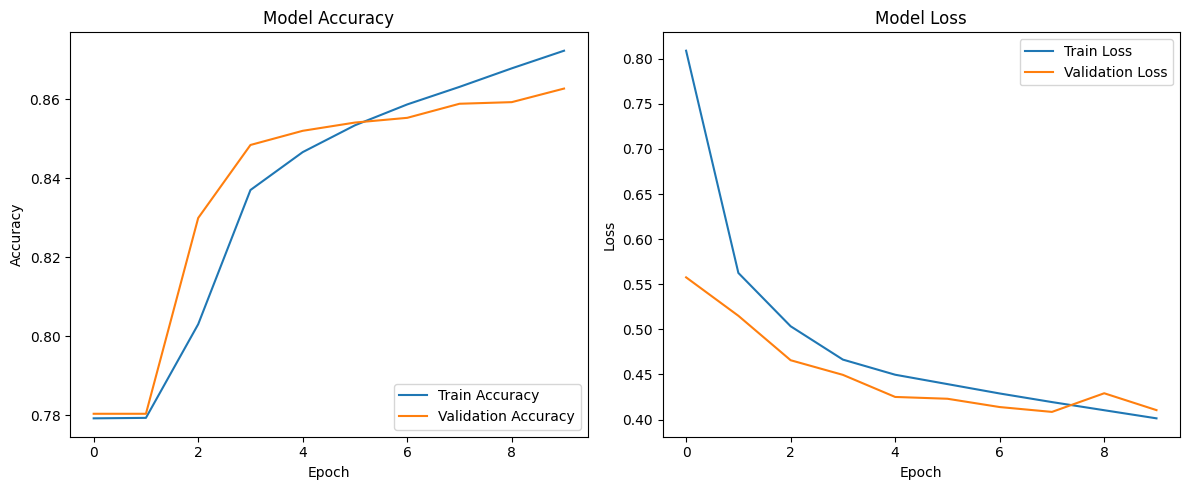

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()